In [1]:
import time
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt


2023-03-15 14:36:10.633776: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 14:36:10.787209: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-15 14:36:10.814378: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-15 14:36:10.814399: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

You do not have pycocotools installed, so KerasCV pycoco metrics are not available. Please run `pip install pycocotools`.
You do not have pyococotools installed, so the `PyCOCOCallback` API is not available.
You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = keras_cv.models.StableDiffusion(img_width=512, img_height=512)


By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [3]:
diffusion_model = (model.diffusion_model)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-03-15 14:36:12.640891: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 14:36:12.641028: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-15 14:36:12.641065: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-15 14:36:12.641085: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-15 14:36:12.641185: W tensorflow/c

In [4]:
diffusion_model.summary()

Model: "diffusion_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 320)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 1280)         410880      ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 activation (Activation)        (None, 1280)         0           ['dense[0][0]']                  
                                                                                    

In [5]:
#images = model.text_to_image("photograph of an astronaut riding a horse", batch_size=3)


def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")


#plot_images(images)


In [6]:
import tensorflow as tf
diffusion_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()])



In [7]:
#TODO document jupyter
import torch
import pickle
import configparser
import sqlite3 as sl
import pandas as pd
import numpy as np
import torch.nn.functional as F
from PIL import Image

configParser = configparser.RawConfigParser()   
configFilePath = r'configuration.txt'
configParser.read(configFilePath)
datasetPathDatabase =  configParser.get('COMMON', 'datasetPathDatabase') + '/dataset.db'

con = sl.connect(datasetPathDatabase)
data = con.execute("SELECT V.ID, V.VIDEO_PATH, V.AGE, V.ETHNICITY, V.GENDER, A.SPEAKER_EMB, A.LANG, F.FACE_PATH  FROM VIDEO V INNER JOIN AUDIO A ON V.ID = A.VIDEO_ID INNER JOIN FACE F ON V.ID = F.VIDEO_ID")
dataGotten = data.fetchall()

pd.set_option('display.max_columns', None)
df = pd.DataFrame(dataGotten,columns = ['ID','VIDEO_PATH','AGE','ETHNICITY','GENDER','SPEAKER_EMB','LANG','FACE_PATH'])


df['SPEAKER_EMB'] = df['SPEAKER_EMB'].apply(lambda x:pickle.loads(x))
with torch.no_grad():
    df['SPEAKER_EMB'] = df['SPEAKER_EMB'].apply(lambda x:F.pad(input=x, pad=(1, 575), mode='constant', value=0) )
    df['SPEAKER_EMB'] = df['SPEAKER_EMB'].apply(lambda x:x.unsqueeze(1).repeat(1,1,77,1) )
    df['SPEAKER_EMB'] = df['SPEAKER_EMB'].apply(lambda x:x.squeeze() )

df['SPEAKER_EMB'] = df['SPEAKER_EMB'].apply(lambda x:x.cpu().detach().numpy() )

def getImage(face_path):
    im = Image.open(face_path)
    #im.load() # required for png.split()

    #im2 = Image.new("RGB", im.size, (255, 255, 255))
    #im2.paste(im, mask=im.split()[3]) # 3 is the alpha channel
    im3 = np.array(im)
    im4 = np.rollaxis(im3,2)
    return im3

df['IMAGE'] = df['FACE_PATH'].apply(lambda x:getImage(x) )
with torch.no_grad():
    input_tensor = torch.tensor(df['SPEAKER_EMB']).cuda()
    output_tensor = torch.tensor(df['IMAGE']).cuda()
    input_tensor = input_tensor.cpu().detach().numpy()
    output_tensor = output_tensor.cpu().detach().numpy()

/tmp/ipykernel_203205/2374486043.py:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1673752754831/work/torch/csrc/utils/tensor_new.cpp:230.)
  input_tensor = torch.tensor(df['SPEAKER_EMB']).cuda()


In [8]:
input_tensor.shape

(1008, 77, 768)

In [9]:




#with torch.no_grad():
#    input_tensor = input_tensor.cpu().detach().numpy()
#    output_tensor = output_tensor.cpu().detach().numpy()





In [10]:
input_tensor.shape

(1008, 77, 768)

In [11]:
np.zeros((1008,320))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
diffusion_model.fit(
    x=[np.zeros((1008,64,64,4)),np.zeros((1008,320)),input_tensor],
    y=output_tensor,
    batch_size=None,
    epochs=1,
    verbose="auto",
    callbacks=None,
    validation_split=0.0,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=True,
)


2023-03-15 14:37:40.528548: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (mklcpu) ran out of memory trying to allocate 16.00GiB (rounded to 17179869184)requested by op diffusion_model/spatial_transformer/basic_transformer_block/cross_attention/MatMul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-03-15 14:37:40.528719: I tensorflow/tsl/framework/bfc_allocator.cc:1034] BFCAllocator dump for mklcpu
2023-03-15 14:37:40.528739: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (256): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-03-15 14:37:40.528752: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-03-15 14:37

ResourceExhaustedError: Graph execution error:

Detected at node 'diffusion_model/spatial_transformer/basic_transformer_block/cross_attention/MatMul' defined at (most recent call last):
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_203205/139521954.py", line 1, in <module>
      diffusion_model.fit(
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/engine/training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras_cv/models/stable_diffusion/diffusion_model.py", line 260, in call
      x = self.transformer_block([x, context])
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras_cv/models/stable_diffusion/diffusion_model.py", line 278, in call
      x = self.attn1([self.norm1(inputs), None]) + inputs
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras_cv/models/stable_diffusion/diffusion_model.py", line 306, in call
      score = td_dot(q, k) * self.scale
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras_cv/models/stable_diffusion/diffusion_model.py", line 342, in td_dot
      cc = keras.backend.batch_dot(aa, bb)
    File "/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/backend.py", line 2637, in batch_dot
      result = tf.matmul(x, y)
Node: 'diffusion_model/spatial_transformer/basic_transformer_block/cross_attention/MatMul'
OOM when allocating tensor with shape[256,4096,4096] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[{{node diffusion_model/spatial_transformer/basic_transformer_block/cross_attention/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_134944]

: 

50/50 [==============================] - 230s 5s/step


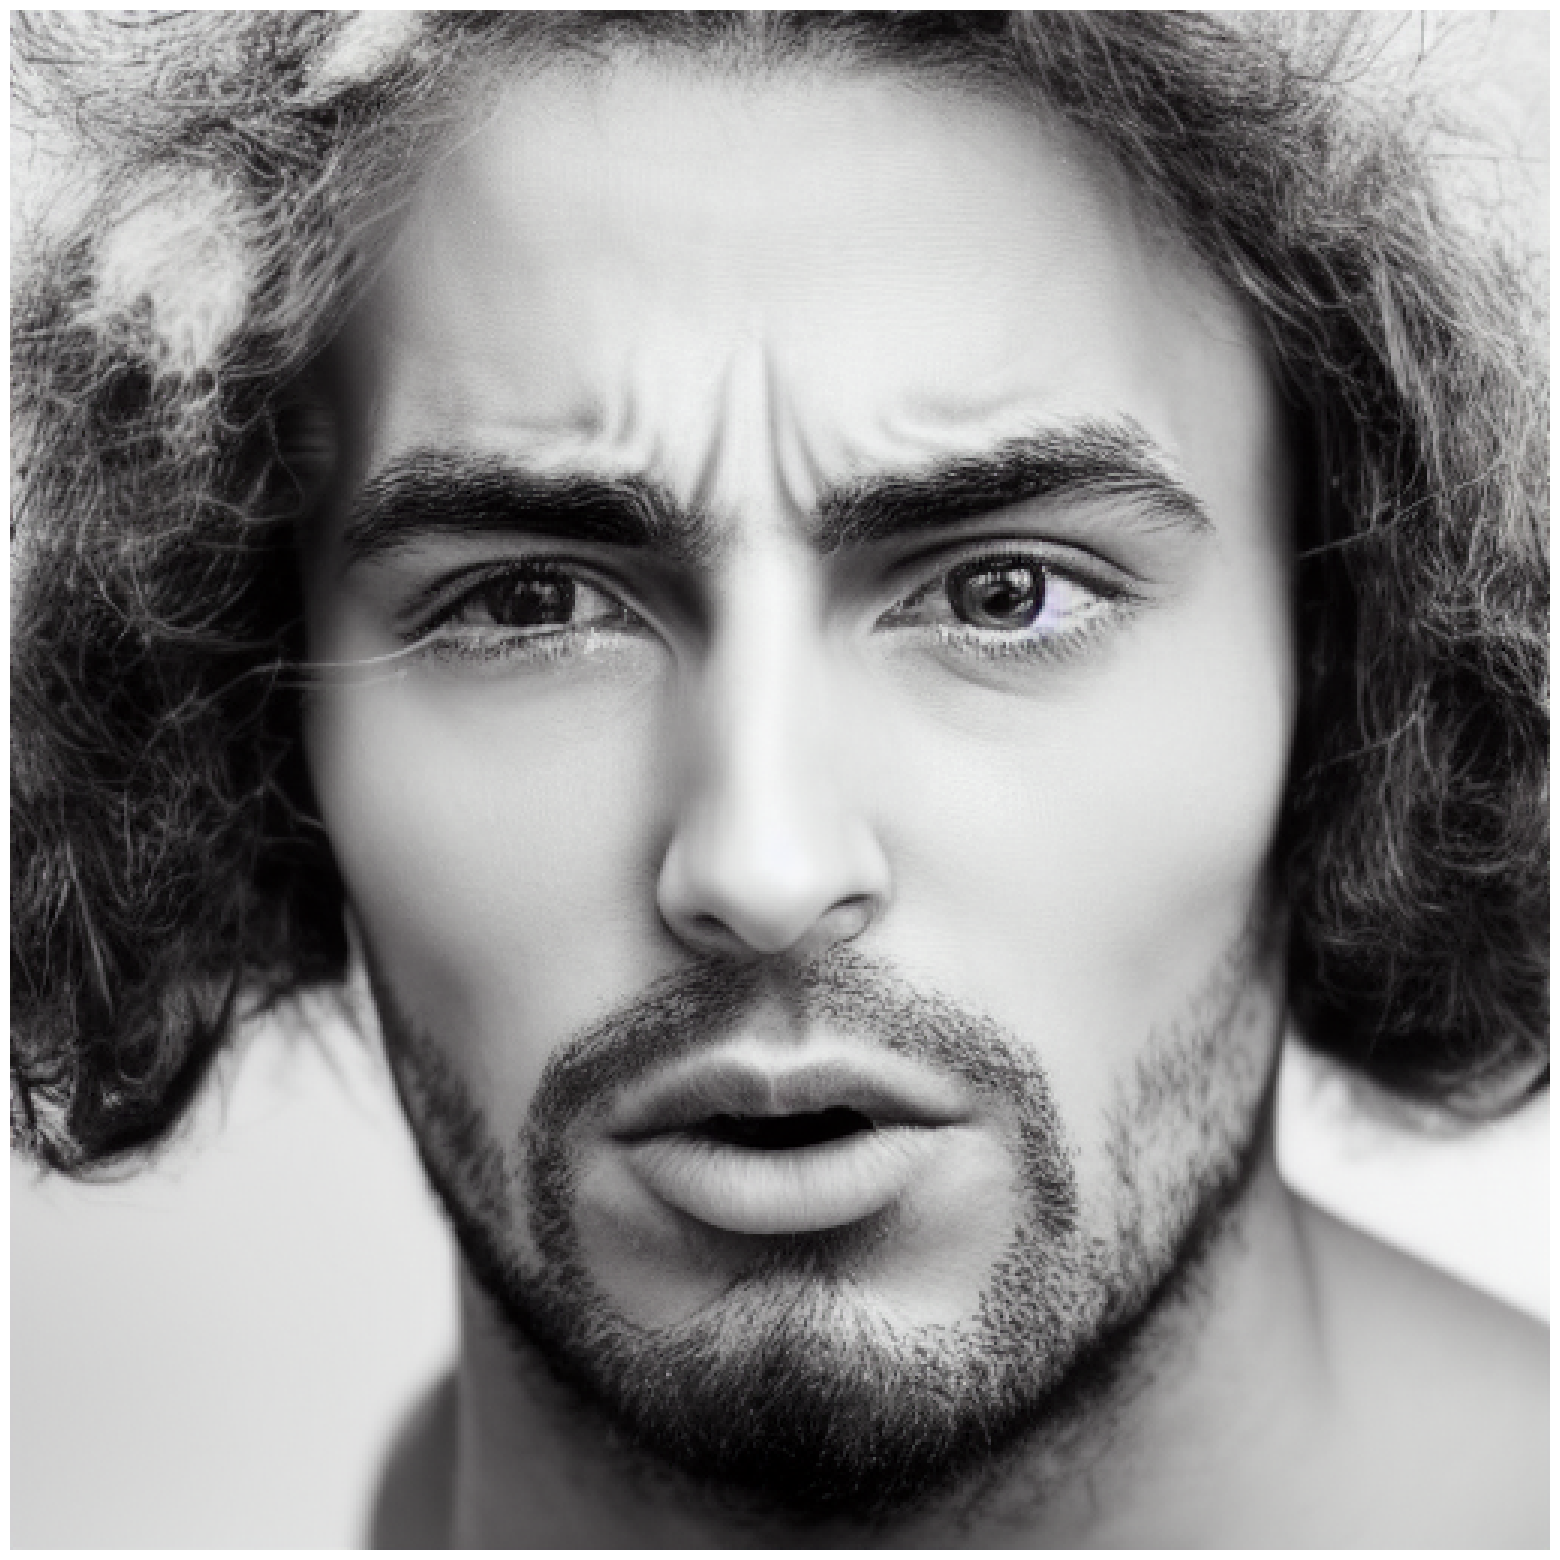

In [ ]:
images = model.text_to_image(
    "A man's face",
    batch_size=1,
)
plot_images(images)


In [ ]:
# https://github.com/keras-team/keras-cv/blob/4fd3a84cb84666644ee52bcc0625f0e4416564dd/keras_cv/models/stable_diffusion/diffusion_model.py#L23
# https://github.com/keras-team/keras-cv/blob/master/keras_cv/models/stable_diffusion/stable_diffusion.py
# https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/
# https://keras.io/examples/generative/random_walks_with_stable_diffusion/
# https://www.kaggle.com/code/apapiu/train-latent-diffusion-in-keras-from-scratch
# https://medium.com/@vedantjumle/image-generation-with-diffusion-models-using-keras-and-tensorflow-9f60aae72ac